In [1]:
import os
import glob
import cv2
import imghdr
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

/var/folders/bk/7hrwt8692xs_m16m4k_44h3m0000gn/T/ipykernel_80119/3633190547.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Limit the VRAM that Tensor Flow can use on my GPU. 
# This avoids any potential OOM (Out of Memory) errors through setting the GPU Memory Consumption Growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = 'data'

In [4]:
image_exts = ['jpeg', 'tiff']

In [5]:
for image_class in os.listdir(data_dir): 
    if (image_class != '.DS_Store'):
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 370 files belonging to 34 classes.


In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

In [9]:
data = data.map(lambda x,y: (x/255, y))
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
data.as_numpy_iterator().next()

(array([[[[0.82990193, 0.46519607, 0.6887255 ],
          [0.8227482 , 0.46450675, 0.68803614],
          [0.81213236, 0.4552696 , 0.67879903],
          ...,
          [0.90686274, 0.5357843 , 0.78382355],
          [0.8948223 , 0.5379596 , 0.77717525],
          [0.89715075, 0.542739  , 0.78195465]],
 
         [[0.82570463, 0.46188724, 0.68541664],
          [0.8202206 , 0.46335784, 0.68688726],
          [0.8120098 , 0.45514706, 0.6786765 ],
          ...,
          [0.9142157 , 0.5421569 , 0.7921569 ],
          [0.9091912 , 0.53664213, 0.7876226 ],
          [0.9098039 , 0.5372549 , 0.7882353 ]],
 
         [[0.80735296, 0.4504902 , 0.67401963],
          [0.8114124 , 0.45454964, 0.67807907],
          [0.8060202 , 0.44915748, 0.6726869 ],
          ...,
          [0.91420037, 0.54557294, 0.7887102 ],
          [0.9209406 , 0.5483915 , 0.79937196],
          [0.91671264, 0.5441636 , 0.795144  ]],
 
         ...,
 
         [[0.69240195, 0.30416667, 0.51593137],
          [0.67596

In [11]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.25)
test_size = int(len(data)*.15)

In [12]:
val_size

3

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
def encode_one_hot(image, label):
    label = tf.one_hot(label, depth=34)
    return image, label

train = train.map(encode_one_hot)
val = val.map(encode_one_hot)

In [16]:
model = Sequential()

In [17]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(34, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │         8,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,106 (14.13 MB)

 Trainable params: 3,705,106 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
logdir='logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - Precision: 0.0315 - Recall: 0.5189 - accuracy: 0.0509 - loss: 3.7354 - val_Precision: 0.0369 - val_Recall: 0.4375 - val_accuracy: 0.0417 - val_loss: 3.4616
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - Precision: 0.0357 - Recall: 0.4523 - accuracy: 0.0648 - loss: 3.4331 - val_Precision: 0.0403 - val_Recall: 0.6250 - val_accuracy: 0.1250 - val_loss: 3.3589
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - Precision: 0.0453 - Recall: 0.7345 - accuracy: 0.1108 - loss: 3.2873 - val_Precision: 0.0461 - val_Recall: 0.8438 - val_accuracy: 0.1354 - val_loss: 3.1278
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - Precision: 0.0477 - Recall: 0.8671 - accuracy: 0.1885 - loss: 3.0396 - val_Precision: 0.0539 - val_Recall: 0.9375 - val_accuracy: 0.2604 - val_loss: 2.6072
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - Precision: 0.0519 - Recall: 0.9343 - accuracy: 0.3094 - loss: 2.5270 - val_Precision: 0.0540 - val_Recall: 0.9479 - 

In [28]:
print(hist.history)

print("\nFinal Training Loss: ", hist.history['loss'][-1])
print("Final Training Accuracy: ", hist.history['accuracy'][-1])
print("Final Training Precision: ", hist.history['Precision'][-1])
print("Final Training Recall: ", hist.history['Recall'][-1])
print("Final Validation Loss: ", hist.history['val_loss'][-1])
print("Final Validation Accuracy: ", hist.history['val_accuracy'][-1])
print("Final Validation Precision: ", hist.history['val_Precision'][-1])
print("Final Validation Recall: ", hist.history['val_Recall'][-1])

{'Precision': [0.030542677268385887, 0.03857972100377083, 0.04424538463354111, 0.04931163787841797, 0.05225180462002754, 0.05455455556511879, 0.05748031660914421, 0.05858960747718811, 0.05950147286057472, 0.06246514245867729, 0.06194690242409706, 0.06747352331876755, 0.06547793000936508, 0.06451612710952759, 0.06875383853912354], 'Recall': [0.5, 0.5044642686843872, 0.7276785969734192, 0.8794642686843872, 0.9375, 0.9732142686843872, 0.9776785969734192, 0.9866071343421936, 0.9910714030265808, 1.0, 1.0, 0.9955357313156128, 1.0, 1.0, 1.0], 'accuracy': [0.0535714291036129, 0.0848214253783226, 0.1205357164144516, 0.21875, 0.3035714328289032, 0.46875, 0.5446428656578064, 0.6785714030265808, 0.6964285969734192, 0.7991071343421936, 0.8169642686843872, 0.8839285969734192, 0.8883928656578064, 0.90625, 0.9151785969734192], 'loss': [3.6908915042877197, 3.404642105102539, 3.2527358531951904, 2.935776472091675, 2.499265432357788, 2.092693567276001, 1.5995800495147705, 1.2411328554153442, 1.1196931600

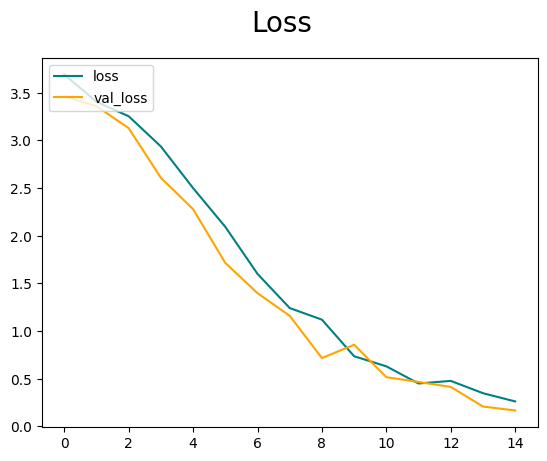

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

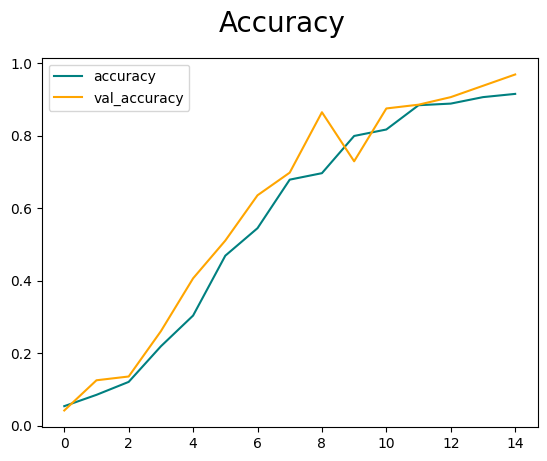

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    y_one_hot = tf.one_hot(y, depth=34)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


2024-08-05 22:02:37.962790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.06490872, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.5762868, shape=(), dtype=float32)


In [34]:
model.save(os.path.join('models','leafclassifier_v4b.h5'))

In [35]:
new_model = load_model(os.path.join('models','leafclassifier_v4b.h5'))